<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h2>Team 7 | Flight Delay Project
<h4> | Future Mindset & Challenge Project | Data Science Challenge
    
<h4>Futurist : Andres Tafur Bravo, Carolina Jativa, Deynag Hu, Haolian Qu, Jaeah Choi, Ruolan Li
<br>Hult International Business School<br><br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

# Classification Modeling Analysis Report

## 1. Introduction

## 2. Importing & Exploring the Dataset
### 2.1 Feature Engineering
#### 1) Data importing
 By using the Tableau Pre-builder, Team 7 have converted categorical data into dummy variables  

In [1]:
# importing libraries
import pandas as pd # data science essentials
import matplotlib.pyplot as plt # essential graphical output
import seaborn as sns # enhanced graphical output
import numpy as np # mathematical essentials
import statsmodels.formula.api as smf # regression modeling
from sklearn.model_selection import train_test_split # train/test split
from sklearn.linear_model import LinearRegression # linear regression (scikit-learn)
import sklearn.linear_model # linear models
import datetime, warnings, scipy 
from datetime import datetime

from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  GridSearchCV 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import make_scorer 
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection  import RandomizedSearchCV


# named dataset
# overall data
df=pd.read_csv('train_ori.csv')

# detail data
flight_delay = pd.read_excel('./train_full.xlsx')

#### 2) Data Preparation

In [2]:
# Data Preparation : Overall
df_TU = df[df.Company.isin(['UG','TU']) ]
df_TU = df_TU.drop(['Year','Company','Fltid'], axis=1)
df_TU_ATA = df_TU[df_TU['Status']=='ATA'].drop(['Status'],axis=1)
df_TU_ATA.info()
df_TU_ATA_dum = pd.get_dummies(df_TU_ATA,
                               columns=['Quarter','Month','Early_mid_late',
                                        'Day_of_week','Duration','Depstn',
                                        'Arrstn','Plane Type'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91083 entries, 218 to 107832
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Quarter         91083 non-null  int64 
 1   Month           91083 non-null  int64 
 2   Early_mid_late  91083 non-null  int64 
 3   Day_of_week     91083 non-null  int64 
 4   Duration        91083 non-null  int64 
 5   duration_min    91083 non-null  int64 
 6   Plane Type      91083 non-null  object
 7   Depstn          91083 non-null  object
 8   Arrstn          91083 non-null  object
 9   Target          91083 non-null  int64 
 10  delay15         91083 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 8.3+ MB


In [3]:
# Data Preparation : detail
########## Top 5 Arrival contries ################

# create empty columns
flight_delay['Arr_france'] = 0
flight_delay['Arr_germany'] = 0
flight_delay['Arr_italy'] = 0
flight_delay['Arr_algeria'] = 0
flight_delay['Arr_saudi'] = 0

# Dummy variable for top 5 countires
for index, value in flight_delay.iterrows():
    if flight_delay.loc[index, 'Country_Arrival'] == "France" :
        flight_delay.loc[index, 'Arr_france'] = 1
    
    elif flight_delay.loc[index, 'Country_Arrival'] == "Germany" :
        flight_delay.loc[index, 'Arr_germany'] = 1
    
    elif flight_delay.loc[index, 'Country_Arrival'] == 'Italy' :
        flight_delay.loc[index, 'Arr_italy'] = 1
        
    elif flight_delay.loc[index, 'Country_Arrival'] == 'Algeria' :
        flight_delay.loc[index, 'Arr_algeria'] = 1
        
    elif flight_delay.loc[index, 'Country_Arrival'] == 'Saudi Arabia' :
        flight_delay.loc[index, 'Arr_saudi'] = 1
        
########## Top departure contries ################
# create empty column
flight_delay['dep_tunisia'] = 0

# Dummy variable 
for index, value in flight_delay.iterrows():
    if flight_delay.loc[index, 'Country_Departure'] == "Tunisia" :
        flight_delay.loc[index, 'dep_tunisia'] = 1

#### 3) Def function code for display decision tree, feature importance & heatmap

In [4]:
########################################
# display_tree
########################################
def display_tree(tree, feature_df, height = 500, width = 800):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    """
    # visualizing the tree
    dot_data = StringIO()

    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width)
    
    return img

########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    features_list = train.columns.values
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,10))
    
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Feature_Importance.png')

        
########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix
    # setting labels
    lbls = labels
    
    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y
                         )
    
    # Heatmap showing in percentage
    Precent = True
    sns.heatmap(cm/np.sum(cm),
                annot=True, 
                fmt='.2%',
                cmap='Blues')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

## 3. ML models
### 3.1 Overall dataset (data name : df)

In [5]:
# train/test split with the df
train_x, test_x, train_y, test_y = train_test_split(
    df_TU_ATA_dum.drop(['delay15','Target'], axis=1),
    df_TU_ATA_dum['delay15'],
    test_size=0.2,
    random_state=42)

#### 1) LASSO Regression

In [6]:
#best alpha for LASSO
lassocv = LassoCV()
lassocv.fit(train_x, train_y)
lassocv.alpha_

0.0032837587628568375

In [7]:
# INSTANTIATING a model object
lasso_model = Lasso(lassocv.alpha_) # default magitude

# FITTING to the training data
lasso_fit = lasso_model.fit(train_x, train_y)

# PREDICTING on new data
lasso_pred = lasso_fit.predict(test_x)

# SCORING the results
print('Lasso Training Score :', lasso_model.score(train_x, train_y).round(4))
print('Lasso Testing Score  :', lasso_model.score(test_x, test_y).round(4))

# saving scoring data for future use
lasso_train_score = lasso_model.score(train_x, train_y).round(4) # using R-square
lasso_test_score  = lasso_model.score(test_x, test_y).round(4)   # using R-square

# displaying and saving the gap between training and testing
print('Lasso Train-Test Gap :', abs(lasso_train_score - lasso_test_score).round(4))
lasso_test_gap = abs(lasso_train_score - lasso_test_score).round(4)

# area under the roc curve (auc)
print('AUC Score            :',roc_auc_score(y_true  = test_y,
                    y_score = lasso_pred).round(decimals = 4))

# saving AUC score for future use
lasso_auc_score = roc_auc_score(y_true  = test_y,
                                 y_score = lasso_pred).round(decimals = 4)

Lasso Training Score : 0.0813
Lasso Testing Score  : 0.0788
Lasso Train-Test Gap : 0.0025
AUC Score            : 0.6684


In [8]:
# zipping each feature name to its coefficient
lasso_model_values = zip(train_x.columns, lasso_fit.coef_.round(decimals = 3))

# setting up a placeholder list to store model features
lasso_model_lst = [('intercept', lasso_fit.intercept_.round(decimals = 2))]

# printing out each feature-coefficient pair one by one
for val in lasso_model_values:
    lasso_model_lst.append(val)

# checking the results
for pair in lasso_model_lst:
    if abs(pair[1])>0.01:
        print(pair)

('intercept', 0.42)
('Quarter_3', 0.089)
('Month_2', -0.029)
('Month_6', -0.02)
('Day_of_week_1', 0.039)
('Day_of_week_3', -0.037)
('Day_of_week_4', -0.032)
('Day_of_week_6', 0.019)
('Duration_1', -0.025)
('Depstn_CMN', -0.011)
('Depstn_DJE', -0.118)
('Depstn_MIR', -0.158)
('Depstn_TUN', 0.068)
('Arrstn_MIR', -0.036)
('Arrstn_TUN', 0.074)
('Plane Type_31B', -0.077)
('Plane Type_320', 0.035)
('Plane Type_32A', 0.03)
('Plane Type_332', 0.104)
('Plane Type_736', -0.042)


In [9]:
model_performance = pd.DataFrame({'Model Name'        : 'LASSO',
                           'Training Accuracy' : lasso_train_score,
                           'Testing Accuracy'  : lasso_test_score,
                           'AUC Score'         : lasso_auc_score,
                           'Confusion Matrix'  : [lasso_model_lst]})

In [10]:
# feature importances 
Lasso_col1=['Quarter_3','Month_2','Month_6','Day_of_week_1','Day_of_week_3',         # |coef|>0.01
           'Day_of_week_4','Day_of_week_6','Duration_1','Depstn_CMN','Depstn_DJE',
           'Depstn_MIR','Depstn_TUN','Arrstn_MIR','Arrstn_TUN',
           'Plane Type_31B', 'Plane Type_320','Plane Type_32A','Plane Type_332',
           'Plane Type_736']  
Lasso_col2=['Quarter_3','Depstn_DJE','Depstn_MIR','Depstn_TUN','Arrstn_TUN',         # |coef|>0.05
           'Plane Type_31B', 'Plane Type_332',]

In [11]:
# test P value
logistic_full = smf.logit(formula = """ delay15 ~
Quarter_3+Month_2+Month_6+Day_of_week_1+Day_of_week_3+Day_of_week_4+Day_of_week_6+
Duration_1+Depstn_CMN+Depstn_DJE+Depstn_MIR+Depstn_TUN+Arrstn_MIR+Arrstn_TUN
""",
                          data=df_TU_ATA_dum)
results_full = logistic_full.fit()

results_full.summary()

Optimization terminated successfully.
         Current function value: 0.648868
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                delay15   No. Observations:                91083
Model:                          Logit   Df Residuals:                    91068
Method:                           MLE   Df Model:                           14
Date:                Thu, 13 May 2021   Pseudo R-squ.:                 0.05396
Time:                        10:27:47   Log-Likelihood:                -59101.
converged:                       True   LL-Null:                       -62472.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0396      0.021      1.872      0.061      -0.002       0.081
Quarter_3         0.4616      0.016     28.574      0.000       0.430       0.493
Month_2          -0.4672      0.033    -14.270      0.000      -0.531      -0.403
Month_6          -0.2038      0.024     -8.322      0.000      -0.252      -0.156
Day_of_week_1     0.2361      0.021     11.503      0.000       0.196       0.276
Day_of_week_3    -0.2878      0.022    -12.830      0.000      -0.332      -0.244
Day_of_week_4    -0.2768      0.023    -12.249      0.000      -0.321      -0.232
Day_of_week_6     0.1691      0.021      8.130      0.000       0.128       0.210
Duration_1       -0.4498      0.025    -18.247      0.000      -0.498      -0.402
Depstn_CMN       -1.0853      0.059    -18.464      0.000      -1.201      -0.970
Depstn_DJE       -0.7760      0.031    -24.818      0.000      -0.837      -0.715
Depstn_MIR       -1.0775      0.038    -28.645      0.000      -1.151      -1.004
Depstn_TUN        0.3737      0.022     17.103      0.000       0.331       0.416
Arrstn_MIR       -0.4683      0.035    -13.370      0.000      -0.537      -0.400
Arrstn_TUN        0.4615      0.022     21.199      0.000       0.419       0.504
=================================================================================
"""

In [12]:
# New trimmed data with Lasso Model
train_x_trim, test_x_trim, train_y_trim, test_y_trim = train_test_split(
    df_TU_ATA_dum[Lasso_col1],
    df_TU_ATA_dum['delay15'],
    test_size=0.2,
    random_state=42)

#### 2) Logistic Regression : Trim

In [13]:

# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'sag', penalty = 'l2',
                            C = 4.3,max_iter=3000,
                            random_state = 219)


# FITTING the training data
logreg_fit = logreg.fit(train_x_trim, train_y_trim)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(test_x_trim)


# SCORING the results
print('LogReg Training ACCURACY:', logreg_fit.score(train_x_trim, train_y_trim).round(3))
print('LogReg Testing  ACCURACY:', logreg_fit.score(test_x_trim, test_y_trim).round(3))

# saving scoring data for future use
logreg_train_score = logreg_fit.score(train_x_trim, train_y_trim).round(3) # accuracy
logreg_test_score  = logreg_fit.score(test_x_trim, test_y_trim).round(3)   # accuracy


# displaying and saving the gap between training and testing
print('LogReg Train-Test Gap   :', abs(logreg_train_score - logreg_test_score).round(4))
logreg_test_gap = abs(logreg_train_score - logreg_test_score).round(4)
# area under the roc curve (auc)
print('LogReg Roc Auc Score    :',roc_auc_score(y_true  = test_y_trim,
                    y_score = logreg_pred).round(decimals = 3))
# saving AUC score for future use
logreg_auc_score = roc_auc_score(y_true  = test_y_trim,
                                 y_score = logreg_pred).round(decimals = 3)

LogReg Training ACCURACY: 0.634
LogReg Testing  ACCURACY: 0.623
LogReg Train-Test Gap   : 0.011
LogReg Roc Auc Score    : 0.601


In [14]:
# zipping each feature name to its coefficient
logreg_model_values = zip(train_x_trim.columns,
                          logreg_fit.coef_.ravel().round(decimals = 3))


# setting up a placeholder list to store model features
logreg_model_lst = [('intercept', logreg_fit.intercept_[0].round(decimals = 3))]


# printing out each feature-coefficient pair one by one
for val in logreg_model_values:
    logreg_model_lst.append(val)
    
# checking the results
for pair in logreg_model_lst:
    #if abs(pair[1])>0.1:
        print(pair)

('intercept', -0.205)
('Quarter_3', 0.45)
('Month_2', -0.425)
('Month_6', -0.224)
('Day_of_week_1', 0.241)
('Day_of_week_3', -0.292)
('Day_of_week_4', -0.284)
('Day_of_week_6', 0.166)
('Duration_1', -0.455)
('Depstn_CMN', -1.105)
('Depstn_DJE', -0.688)
('Depstn_MIR', -1.011)
('Depstn_TUN', 0.207)
('Arrstn_MIR', -0.439)
('Arrstn_TUN', 0.304)
('Plane Type_31B', -0.229)
('Plane Type_320', 0.527)
('Plane Type_32A', 0.449)
('Plane Type_332', 1.311)
('Plane Type_736', 0.091)


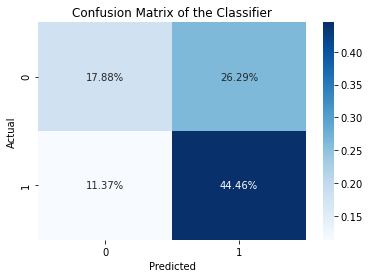

In [15]:
# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = test_y_trim, y_pred = logreg_pred).ravel()

visual_cm(true_y = test_y_trim,
          pred_y = logreg_pred,
          labels = ['Delay', 'NoDelay']) #Label is not working

In [16]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'        : 'LogReg',
                           'Training Accuracy' : logreg_train_score,
                           'Testing Accuracy'  : logreg_test_score,
                           'AUC Score'         : logreg_auc_score,
                           'Confusion Matrix'  : (logreg_tn,
                                                  logreg_fp,
                                                  logreg_fn,
                                                  logreg_tp)},
                           ignore_index = True)
model_performance

,Model Name,Training Accuracy,Testing Accuracy,AUC Score,Confusion Matrix
0,LASSO,0.0813,0.0788,0.6684,"[(intercept, 0.42), (duration_min, 0.001), (Qu..."
1,LogReg,0.6340,0.6230,0.6010,"(3257, 4789, 2071, 8100)"


#### 3) Random Forest

In [17]:
# declaring a hyperparameter space
estimator_space  = pd.np.arange(10, 300, 10)
criterion_space  = ['gini', 'entropy']
bootstrap_space  = [True, False]
warm_start_space = [True, False]


# creating a hyperparameter grid
param_grid = {'n_estimators'     : estimator_space,
              'criterion'        : criterion_space,
              'bootstrap'        : bootstrap_space,
              'warm_start'       : warm_start_space}


# INSTANTIATING the model object without hyperparameters
forest_grid = RandomForestClassifier(random_state = 219)


# GridSearchCV object
forest_cv = RandomizedSearchCV(estimator           = forest_grid,
                               param_distributions = param_grid,
                               cv         = 3,
                               n_iter     = 250,
                               scoring    = make_scorer(roc_auc_score,
                                            needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
forest_cv.fit(train_x_trim, train_y_trim)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", forest_cv.best_params_)
print("Tuned Training AUC:", forest_cv.best_score_.round(4))

#Tuned FULL Parameters  : {'warm_start': False, 'n_estimators': 90, 'min_samples_leaf': 21, 'max_depth': 9, 'criterion': 'entropy', 'bootstrap': True}
# Tuned Training AUC: 0.6157

#Tuned TRIM Parameters  : {'warm_start': True, 'n_estimators': 80, 'min_samples_leaf': 1, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False}
#Tuned Training AUC: 0.6146

<ipython-input-17-4afe70a9bc3e>:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  estimator_space  = pd.np.arange(10, 300, 10)
C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 232 is smaller than n_iter=250. Running 232 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [18]:
# Random Forest full

rf = RandomForestClassifier(warm_start=False,
                            n_estimators=90,
                            min_samples_leaf=21,
                            criterion='entropy', 
                            random_state=219)
rf_fit = rf.fit(train_x, train_y)
rf_pred = rf.predict(test_x)

print('Training ACCURACY:', rf_fit.score(train_x, train_y).round(3))
print('Testing  ACCURACY:', rf_fit.score(test_x, test_y).round(3))

rf_train_score=rf_fit.score(train_x, train_y).round(3)
rf_test_score=rf_fit.score(test_x, test_y).round(3)
print('RF Train-Test Gap:', abs(rf_train_score - rf_test_score).round(3))
rf_test_gap = abs(rf_train_score - rf_test_score).round(3)
# saving AUC score
print('AUC Score        :', roc_auc_score(y_true  = test_y,
                                          y_score = rf_pred).round(3))
rf_auc_score = roc_auc_score(y_true  = test_y,
                             y_score = rf_pred).round(decimals = 3)

Training ACCURACY: 0.678
Testing  ACCURACY: 0.666
RF Train-Test Gap: 0.012
AUC Score        : 0.645


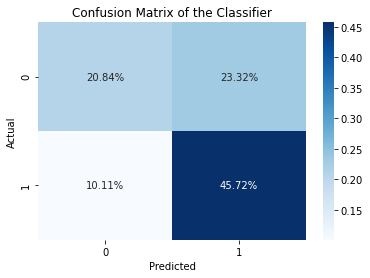

In [19]:
# unpacking the confusion matrix
rf_tn, \
rf_fp, \
rf_fn, \
rf_tp = confusion_matrix(y_true = test_y, y_pred = rf_pred).ravel()

visual_cm(true_y = test_y,
          pred_y = rf_pred,
          labels = ['Delay', 'NoDelay'])

Text(0, 0.5, 'Feature')

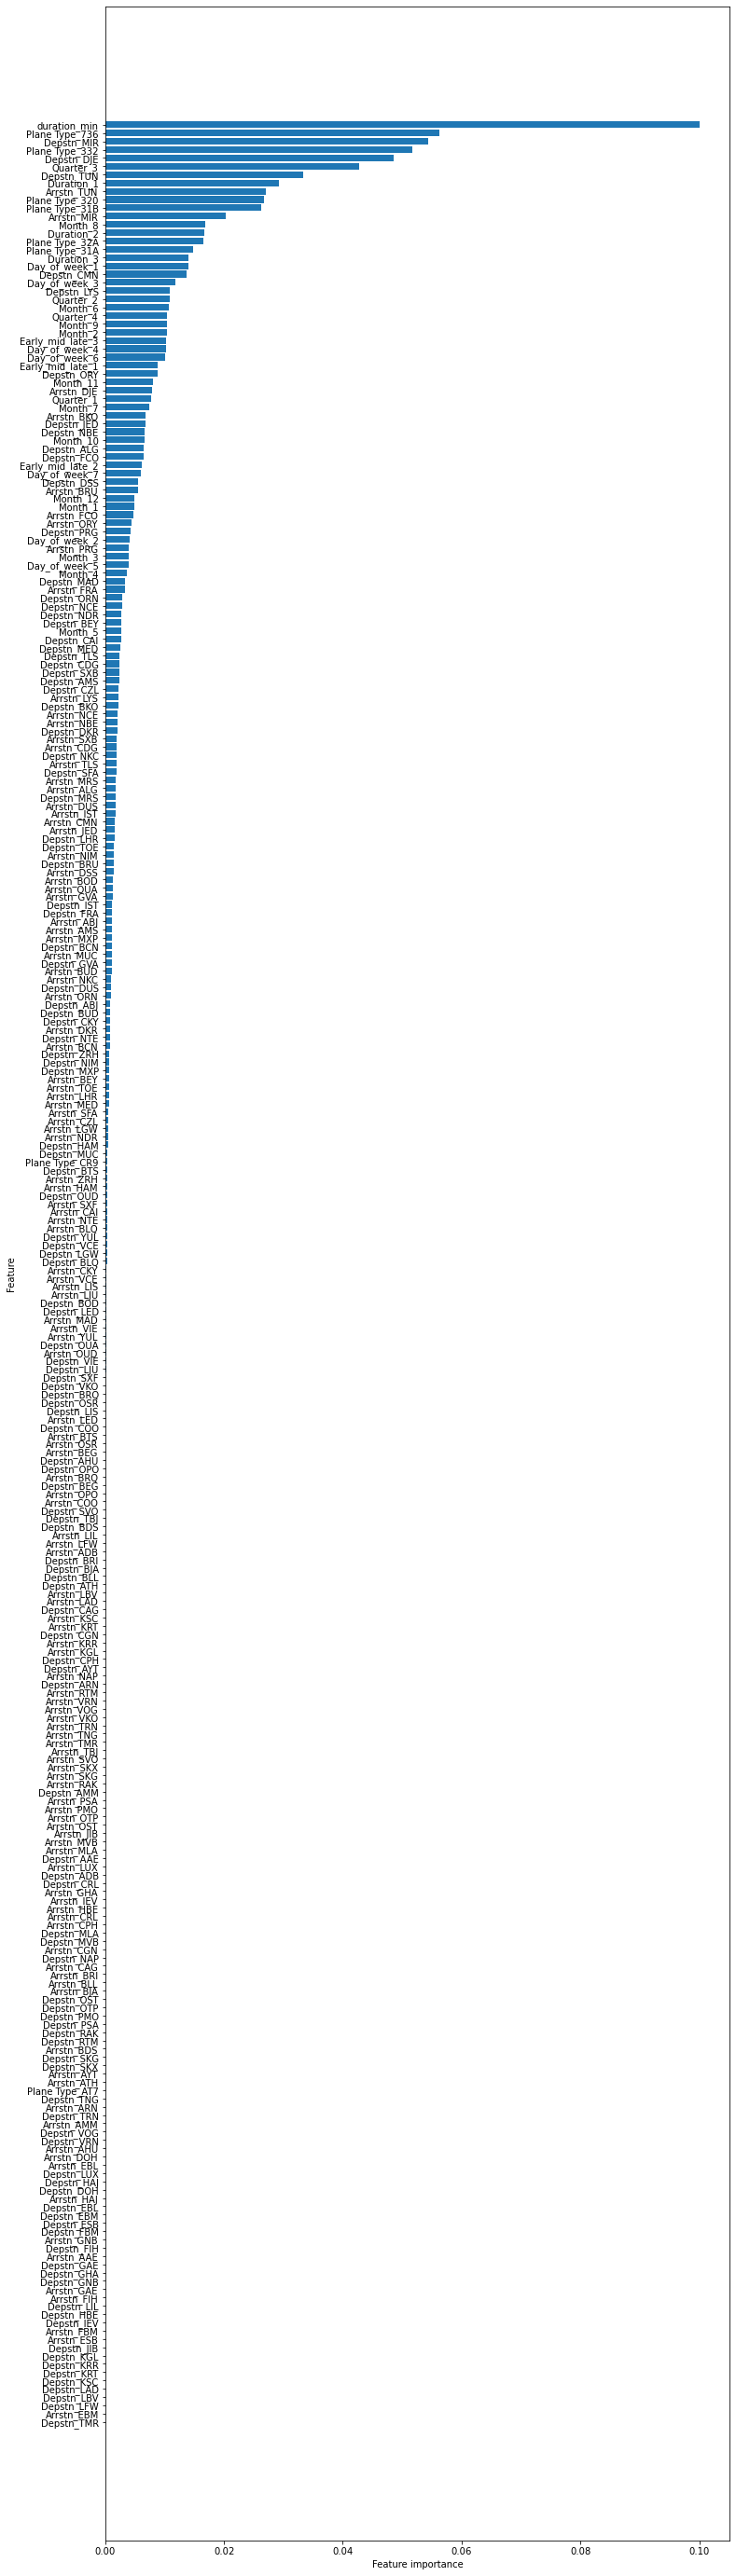

In [20]:
features_list = train_x.columns.values
feature_importance = rf_fit.feature_importances_
sorted_idx = np.argsort(feature_importance)

# setting plot window
fig, ax = plt.subplots(figsize=(12,50))

plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel("Feature importance")
plt.ylabel("Feature")

In [21]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'        : 'Random Forest',
                           'Training Accuracy' : rf_train_score,
                           'Testing Accuracy'  : rf_test_score,
                           'AUC Score'         : rf_auc_score,
                           'Confusion Matrix'  : (rf_tn,
                                                  rf_fp,
                                                  rf_fn,
                                                  rf_tp)},
                           ignore_index = True)
model_performance

,Model Name,Training Accuracy,Testing Accuracy,AUC Score,Confusion Matrix
0,LASSO,0.0813,0.0788,0.6684,"[(intercept, 0.42), (duration_min, 0.001), (Qu..."
1,LogReg,0.6340,0.6230,0.6010,"(3257, 4789, 2071, 8100)"
2,Random Forest,0.6780,0.6660,0.6450,"(3797, 4249, 1842, 8329)"


In [22]:
# Random Forest TRIMMED
#{'warm_start': True, 'n_estimators': 80, 'min_samples_leaf': 1, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False}
rf_trim = RandomForestClassifier(warm_start=True,
                            n_estimators=80,
                            min_samples_leaf=1,
                            criterion='gini',
                            random_state=219)
rf_trim_fit = rf_trim.fit(train_x_trim, train_y_trim)
rf_trim_pred = rf_trim.predict(test_x_trim)

print('Training ACCURACY:', rf_trim_fit.score(train_x_trim, train_y_trim).round(3))
print('Testing  ACCURACY:', rf_trim_fit.score(test_x_trim, test_y_trim).round(3))

rf_trim_train_score=rf_trim_fit.score(train_x_trim, train_y_trim).round(3)
rf_trim_test_score=rf_trim_fit.score(test_x_trim, test_y_trim).round(3)
print('RF trim Train-Test Gap:', abs(rf_trim_train_score - rf_trim_test_score).round(3))
rf_trim_test_gap = abs(rf_trim_train_score - rf_trim_test_score).round(3)
# saving AUC score
print('AUC Score        :', roc_auc_score(y_true  = test_y_trim,
                                          y_score = rf_trim_pred).round(3))
rf_trim_auc_score = roc_auc_score(y_true  = test_y_trim,
                             y_score = rf_trim_pred).round(decimals = 3)

Training ACCURACY: 0.653
Testing  ACCURACY: 0.639
RF trim Train-Test Gap: 0.014
AUC Score        : 0.622


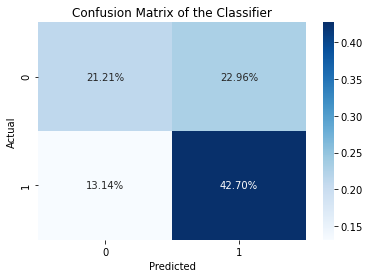

In [23]:
# unpacking the confusion matrix
rf_trim_tn, \
rf_trim_fp, \
rf_trim_fn, \
rf_trim_tp = confusion_matrix(y_true = test_y_trim, y_pred = rf_trim_pred).ravel()

visual_cm(true_y = test_y_trim,
          pred_y = rf_trim_pred,
          labels = ['Delay', 'NoDelay'])

C:\Users\User\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


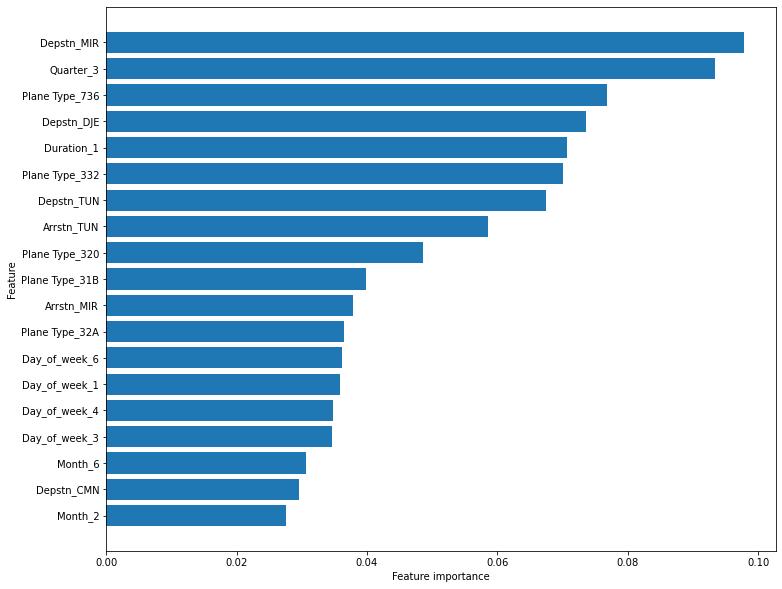

In [24]:
plot_feature_importances(rf_trim.fit(train_x_trim, train_y_trim),
                         train = train_x_trim,
                         export = False)

In [25]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'        : 'RF-trim',
                           'Training Accuracy' : rf_trim_train_score,
                           'Testing Accuracy'  : rf_trim_test_score,
                           'AUC Score'         : rf_trim_auc_score,
                           'Confusion Matrix'  : (rf_trim_tn,
                                                  rf_trim_fp,
                                                  rf_trim_fn,
                                                  rf_trim_tp)},
                           ignore_index = True)
model_performance

,Model Name,Training Accuracy,Testing Accuracy,AUC Score,Confusion Matrix
0,LASSO,0.0813,0.0788,0.6684,"[(intercept, 0.42), (duration_min, 0.001), (Qu..."
1,LogReg,0.6340,0.6230,0.6010,"(3257, 4789, 2071, 8100)"
2,Random Forest,0.6780,0.6660,0.6450,"(3797, 4249, 1842, 8329)"
3,RF-trim,0.6530,0.6390,0.6220,"(3863, 4183, 2393, 7778)"


#### 4) Classification Tree

In [26]:

# declaring a hyperparameter space
criterion_space = ['gini', 'entropy']
splitter_space  = ['best', 'random']
depth_space     = pd.np.arange(1, 50, 10)
leaf_space      = pd.np.arange(1, 101, 10)
max_features_space = ["auto", "sqrt", "log2"]


# creating a hyperparameter grid
param_grid = {'criterion'        : criterion_space,
              'splitter'         : splitter_space,
              'max_depth'        : depth_space,
              'min_samples_leaf' : leaf_space,
              'max_features'     : max_features_space}


# INSTANTIATING the model object without hyperparameters
tuned_tree = DecisionTreeClassifier(random_state = 219)


# RandomizedSearchCV object
tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
                                   param_distributions   = param_grid,
                                   cv                    = 3,
                                   n_iter                = 1000,
                                   random_state          = 219,
                                   scoring = make_scorer(roc_auc_score,
                                             needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
tuned_tree_cv.fit(train_x, train_y)

# printing the optimal parameters and best score
print("Tuned Parameters  :", tuned_tree_cv.best_params_)
print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

#Tuned Parameters  : {'splitter': 'best', 'min_samples_leaf': 11, 'max_features': 'auto', 'max_depth': 41, 'criterion': 'gini'}
#Tuned Training AUC: 0.6274

#Tuned trim Parameters  : {'splitter': 'random', 'min_samples_leaf': 9, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'entropy'}


<ipython-input-26-ef83650b3e77>:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  depth_space     = pd.np.arange(1, 50, 10)
<ipython-input-26-ef83650b3e77>:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  leaf_space      = pd.np.arange(1, 101, 10)
C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 600 is smaller than n_iter=1000. Running 600 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [27]:
# INSTANTIATING a classification tree object FULL
tree = DecisionTreeClassifier(criterion='gini',
                            splitter='best',
                            max_features='auto',
                             min_samples_leaf=11,
                              max_depth=41,
                             random_state = 219)


# FITTING the training data
tree_fit  = tree.fit(train_x, train_y)


# PREDICTING on new data
tree_pred = tree_fit.predict(test_x)


# SCORING the model
print('Training ACCURACY:', tree_fit.score(train_x, train_y).round(3))
print('Testing  ACCURACY:', tree_fit.score(test_x, test_y).round(3))
print('AUC Score        :', roc_auc_score(y_true  = test_y,
                                          y_score = tree_pred).round(3))
# saving scoring data for future use
tree_train_score = tree_fit.score(train_x, train_y).round(3) # accuracy
tree_test_score  = tree_fit.score(test_x, test_y).round(3)   # accuracy
tree_auc_score   = roc_auc_score(y_true  = test_y,
                                        y_score = tree_pred).round(3) # auc

print('Tree Train-Test Gap:', abs(tree_train_score - tree_test_score).round(3))
tree_test_gap = abs(tree_train_score - tree_test_score).round(3)

Training ACCURACY: 0.662
Testing  ACCURACY: 0.642
AUC Score        : 0.628
Tree Train-Test Gap: 0.02


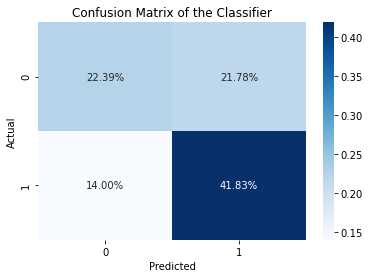

In [28]:
# unpacking the confusion matrix
tree_tn, \
tree_fp, \
tree_fn, \
tree_tp = confusion_matrix(y_true = test_y, y_pred = tree_pred).ravel()

visual_cm(true_y = test_y,
          pred_y = tree_pred,
          labels = ['Delay', 'NoDelay'])

Text(0, 0.5, 'Feature')

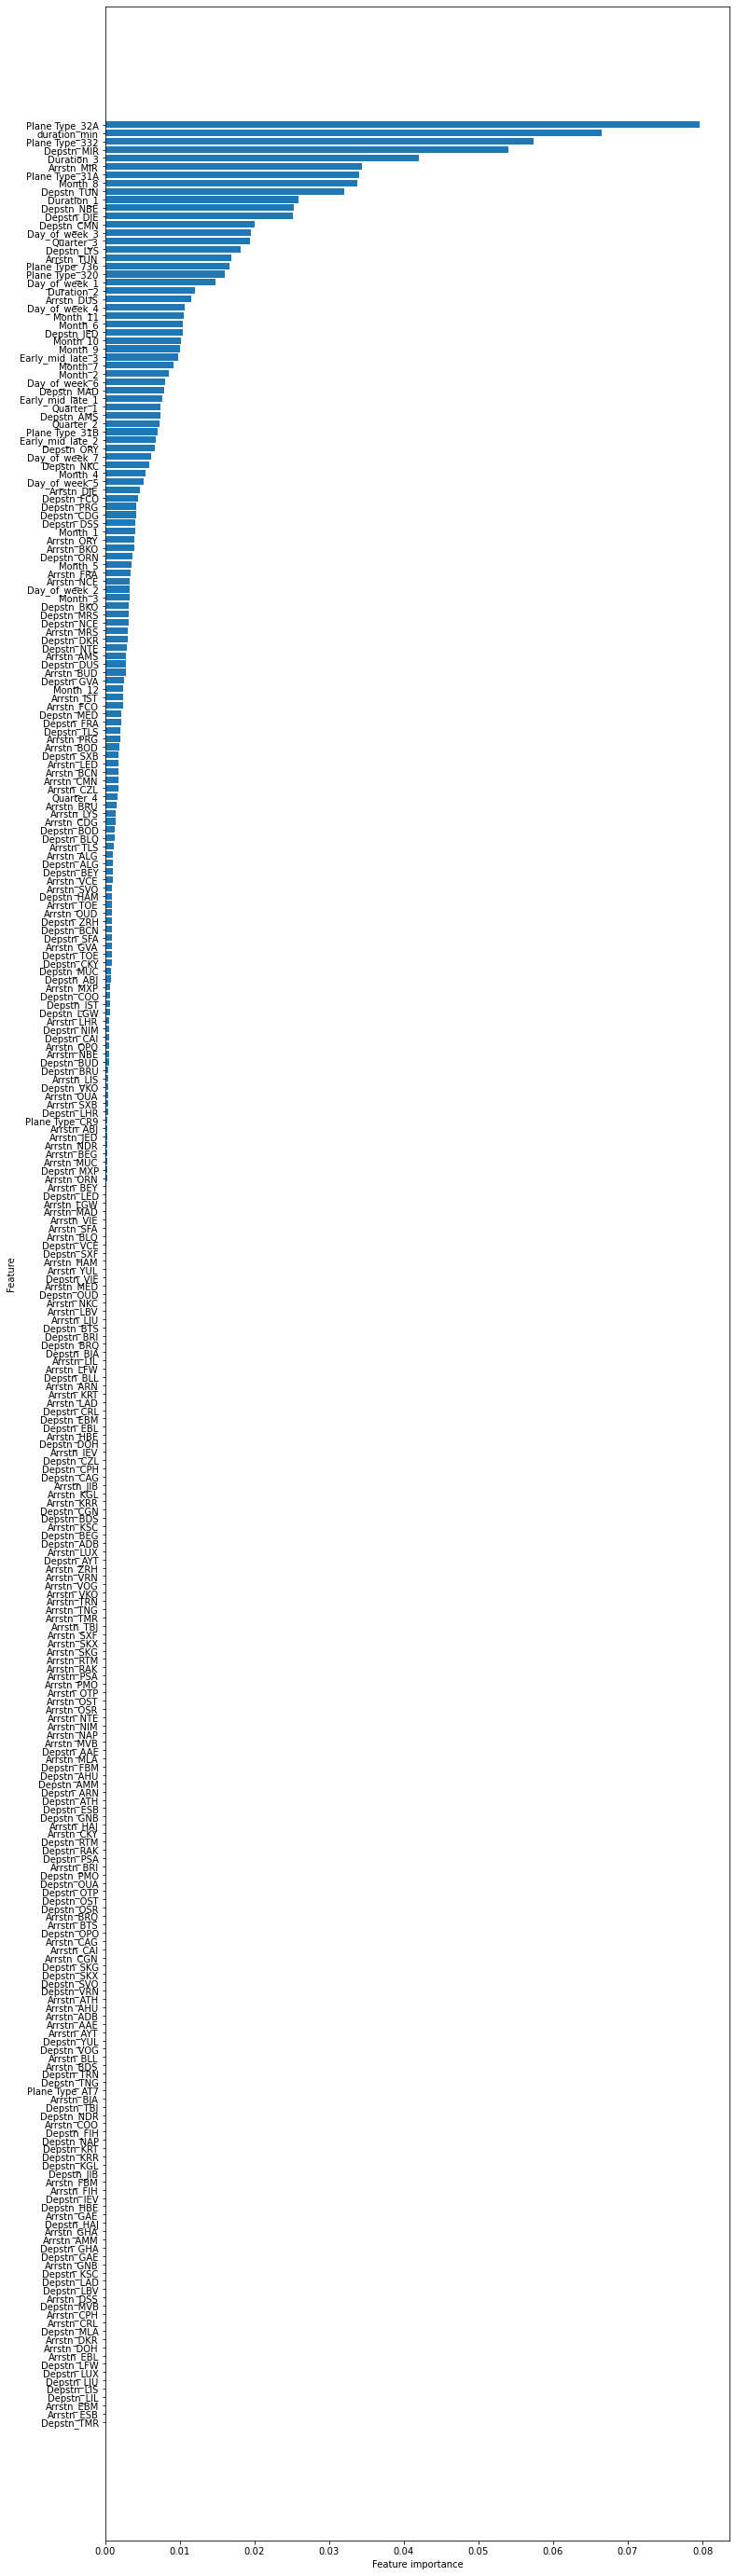

In [29]:
features_list = train_x.columns.values
feature_importance = tree_fit.feature_importances_
sorted_idx = np.argsort(feature_importance)

# setting plot window
fig, ax = plt.subplots(figsize=(12,50))

plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel("Feature importance")
plt.ylabel("Feature")

In [30]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'        : 'Full Tree',
                           'Training Accuracy' : tree_train_score,
                           'Testing Accuracy'  : tree_test_score,
                           'AUC Score'         : tree_auc_score,
                           'Confusion Matrix'  : (tree_tn,
                                                  tree_fp,
                                                  tree_fn,
                                                  tree_tp)},
                           ignore_index = True)
model_performance

,Model Name,Training Accuracy,Testing Accuracy,AUC Score,Confusion Matrix
0,LASSO,0.0813,0.0788,0.6684,"[(intercept, 0.42), (duration_min, 0.001), (Qu..."
1,LogReg,0.6340,0.6230,0.6010,"(3257, 4789, 2071, 8100)"
2,Random Forest,0.6780,0.6660,0.6450,"(3797, 4249, 1842, 8329)"
3,RF-trim,0.6530,0.6390,0.6220,"(3863, 4183, 2393, 7778)"
4,Full Tree,0.6620,0.6420,0.6280,"(4079, 3967, 2550, 7621)"


In [31]:
# INSTANTIATING a classification tree object trim
trim_tree = DecisionTreeClassifier(criterion='entropy',
                                    splitter='random',
                                    max_features='auto',
                                   min_samples_leaf=9,
                                   max_depth=8,
                                     random_state = 219)


# FITTING the training data
trim_tree_fit  = trim_tree.fit(train_x_trim, train_y_trim)


# PREDICTING on new data
trim_tree_pred = trim_tree_fit.predict(test_x_trim)


# SCORING the model
print('Training ACCURACY:', trim_tree_fit.score(train_x_trim, train_y_trim).round(4))
print('Testing  ACCURACY:', trim_tree_fit.score(test_x_trim, test_y_trim).round(4))
print('AUC Score        :', roc_auc_score(y_true  = test_y_trim,
                                          y_score = trim_tree_pred).round(4))
# saving scoring data for future use
trim_tree_train_score = trim_tree_fit.score(train_x_trim, train_y_trim).round(4) # accuracy
trim_tree_test_score  = trim_tree_fit.score(test_x_trim, test_y_trim).round(4)   # accuracy
# saving auc score
trim_tree_auc_score   = roc_auc_score(y_true  = test_y_trim,
                                        y_score = trim_tree_pred).round(4) # auc

print('Trim Tree Train-Test Gap:', abs(trim_tree_train_score - trim_tree_test_score).round(3))
trim_tree_test_gap = abs(trim_tree_train_score - trim_tree_test_score).round(3)

Training ACCURACY: 0.6283
Testing  ACCURACY: 0.6245
AUC Score        : 0.6034
Trim Tree Train-Test Gap: 0.004


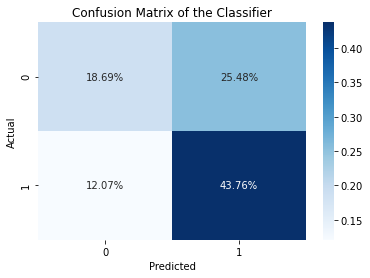

In [32]:
# unpacking the confusion matrix
trim_tree_tn, \
trim_tree_fp, \
trim_tree_fn, \
trim_tree_tp = confusion_matrix(y_true = test_y_trim, y_pred = trim_tree_pred).ravel()

visual_cm(true_y = test_y_trim,
          pred_y = trim_tree_pred,
          labels = ['Delay', 'NoDelay'])

In [ ]:
plot_feature_importances(trim_tree.fit(train_x_trim, train_y_trim),
                         train = train_x_trim,
                         export = False)

In [33]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'        : 'Trim Tree',
                           'Training Accuracy' : trim_tree_train_score,
                           'Testing Accuracy'  : trim_tree_test_score,
                           'AUC Score'         : trim_tree_auc_score,
                           'Confusion Matrix'  : (trim_tree_tn,
                                                  trim_tree_fp,
                                                  trim_tree_fn,
                                                  trim_tree_tp)},
                           ignore_index = True)

In [34]:
from six import StringIO 
import pydotplus 
from IPython.display import Image     
display_tree(tree       = tuned_tree_fit,
             feature_df = train_x_trim)

NameError: name 'tuned_tree_fit' is not defined

#### 5) Gradient Boosted Machines

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
# INSTANTIATING the model object without hyperparameters
trim_gbm= GradientBoostingClassifier(loss          = 'deviance',
                                              learning_rate = 0.1,
                                              n_estimators  = 100,
                                              criterion     = 'friedman_mse',
                                              max_depth     = 3,
                                              warm_start    = False,
                                              random_state  = 219)


# FIT step is needed as we are not using .best_estimator
trim_gbm_fit = trim_gbm.fit(train_x_trim, train_y_trim)


# PREDICTING based on the testing set
trim_gbm_pred = trim_gbm_fit.predict(test_x_trim)


# SCORING the results
print('Training ACCURACY:', trim_gbm_fit.score(train_x_trim, train_y_trim).round(4))
print('Testing ACCURACY :', trim_gbm_fit.score(test_x_trim, test_y_trim).round(4))
print('AUC Score        :', roc_auc_score(y_true  = test_y_trim,
                                          y_score = trim_gbm_pred).round(4))

trim_gbm_train_score=trim_gbm_fit.score(train_x_trim, train_y_trim).round(4)
trim_gbm_test_score=trim_gbm_fit.score(test_x_trim, test_y_trim).round(4)
trim_gbm_auc=roc_auc_score(y_true  = test_y_trim, y_score = trim_gbm_pred).round(4)

print('Trim GBM Train-Test Gap:', abs(trim_gbm_train_score - trim_gbm_test_score).round(3))
trim_gbm_test_gap = abs(trim_gbm_train_score - trim_gbm_test_score).round(3)

Training ACCURACY: 0.6413
Testing ACCURACY : 0.6319
AUC Score        : 0.609
Trim GBM Train-Test Gap: 0.009


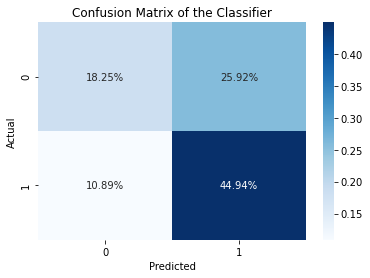

In [36]:
# unpacking the confusion matrix
trim_gbm_tn, \
trim_gbm_fp, \
trim_gbm_fn, \
trim_gbm_tp = confusion_matrix(y_true = test_y_trim, y_pred = trim_gbm_pred).ravel()

visual_cm(true_y = test_y_trim,
          pred_y = trim_gbm_pred,
          labels = ['Delay', 'NoDelay'])

In [ ]:
plot_feature_importances(trim_gbm.fit(train_x_trim, train_y_trim),
                         train = train_x_trim,
                         export = False)

In [37]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'        : 'Trim GBM',
                           'Training Accuracy' : trim_gbm_train_score,
                           'Testing Accuracy'  : trim_gbm_test_score,
                           'AUC Score'         : trim_gbm_auc,
                           'Confusion Matrix'  : (trim_gbm_tn,
                                                  trim_gbm_fp,
                                                  trim_gbm_fn,
                                                  trim_gbm_tp)},
                           ignore_index = True)

In [38]:
### FULL GBM
# INSTANTIATING the model object without hyperparameters
gbm= GradientBoostingClassifier(loss          = 'deviance',
                                              learning_rate = 0.1,
                                              n_estimators  = 100,
                                              criterion     = 'friedman_mse',
                                              max_depth     = 3,
                                              warm_start    = False,
                                              random_state  = 219)


# FIT step is needed as we are not using .best_estimator
gbm_fit = gbm.fit(train_x, train_y)


# PREDICTING based on the testing set
gbm_pred = gbm_fit.predict(test_x)


# SCORING the results
print('Training ACCURACY:', gbm_fit.score(train_x, train_y).round(4))
print('Testing ACCURACY :', gbm_fit.score(test_x, test_y).round(4))
print('AUC Score        :', roc_auc_score(y_true  = test_y,
                                          y_score = gbm_pred).round(4))

gbm_train_score=gbm_fit.score(train_x, train_y).round(4)
gbm_test_score=gbm_fit.score(test_x, test_y).round(4)
gbm_auc=roc_auc_score(y_true  = test_y, y_score = gbm_pred).round(4)

print('GBM Train-Test Gap:', abs(gbm_train_score - gbm_test_score).round(3))
gbm_test_gap = abs(gbm_train_score - gbm_test_score).round(3)

Training ACCURACY: 0.6605
Testing ACCURACY : 0.6519
AUC Score        : 0.6277
GBM Train-Test Gap: 0.009


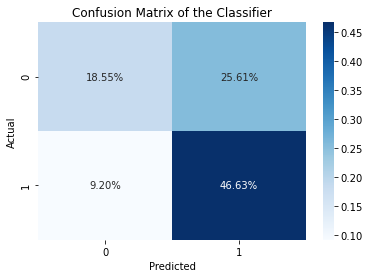

In [39]:
# unpacking the confusion matrix
gbm_tn, \
gbm_fp, \
gbm_fn, \
gbm_tp = confusion_matrix(y_true = test_y, y_pred = gbm_pred).ravel()

visual_cm(true_y = test_y,
          pred_y = gbm_pred,
          labels = ['Delay', 'NoDelay'])

Text(0, 0.5, 'Feature')

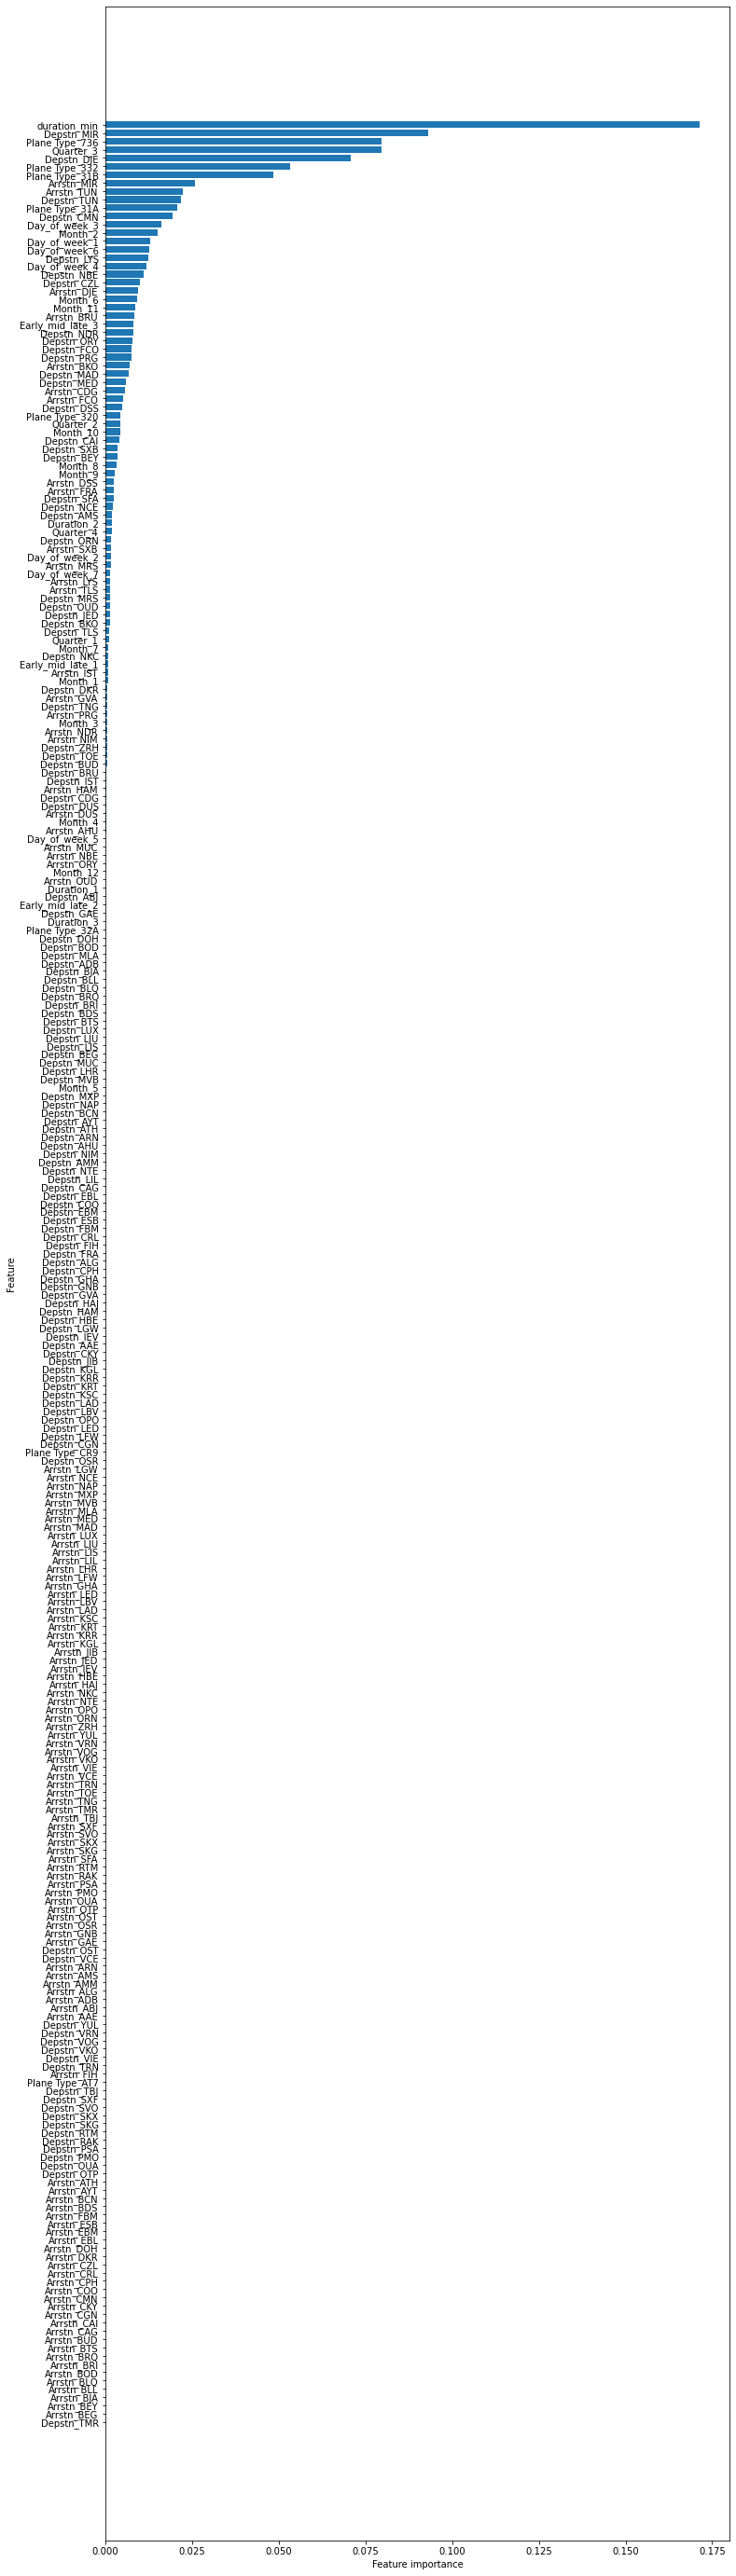

In [40]:
features_list = train_x.columns.values
feature_importance = gbm_fit.feature_importances_
sorted_idx = np.argsort(feature_importance)

# setting plot window
fig, ax = plt.subplots(figsize=(12,50))

plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel("Feature importance")
plt.ylabel("Feature")

In [ ]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'        : 'GBM',
                           'Training Accuracy' : gbm_train_score,
                           'Testing Accuracy'  : gbm_test_score,
                           'AUC Score'         : gbm_auc,
                           'Confusion Matrix'  : (gbm_tn,
                                                  gbm_fp,
                                                  gbm_fn,
                                                  gbm_tp)},
                           ignore_index = True)
model_performance

#### 6) XGboost

In [ ]:
#Installing code before start
#%conda install XGBoost 

import xgboost
xgb = xgboost.XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=1000, objective='binary:logistic',
                            nthread=-1, subsample=0.5, colsample_bytree=0.8)

xgb_fit=xgb.fit(train_x, train_y, eval_metric='error', verbose=True)
xgb_pred = xgb.predict(test_x)

print('Training ACCURACY:', xgb_fit.score(train_x, train_y).round(3))
print('Testing ACCURACY :', xgb_fit.score(test_x, test_y).round(3))
print('AUC Score        :', roc_auc_score(test_y, xgb_pred).round(3))
xgb_train_score=xgb_fit.score(train_x, train_y).round(3)
xgb_test_score=xgb_fit.score(test_x, test_y).round(3)
xgb_auc = roc_auc_score(test_y, xgb_pred).round(3)

print('XGB Train-Test Gap:', abs(xgb_train_score - xgb_test_score).round(3))
xgb_test_gap = abs(xgb_train_score - xgb_test_score).round(3)

In [ ]:
# unpacking the confusion matrix
confusion_matrix(test_y,xgb_pred)
xgb_tn, \
xgb_fp, \
xgb_fn, \
xgb_tp = confusion_matrix(y_true = test_y, y_pred = xgb_pred).ravel()

visual_cm(true_y = test_y,
          pred_y = xgb_pred,
          labels = ['Delay', 'NoDelay'])

In [ ]:
xgboost.plot_importance(xgb_fit,max_num_features=20,importance_type='gain')

In [ ]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'        : 'XGBoost',
                           'Training Accuracy' : xgb_train_score,
                           'Testing Accuracy'  : xgb_test_score,
                           'AUC Score'         : xgb_auc,
                           'Confusion Matrix'  : (xgb_tn,
                                                  xgb_fp,
                                                  xgb_fn,
                                                  xgb_tp)},
                           ignore_index = True)
model_performance

In [ ]:
# TRIM XGB
xgb_trim = xgboost.XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=1000, objective='binary:logistic',
                            nthread=-1, subsample=0.5, colsample_bytree=0.8)

xgb_trim_fit=xgb_trim.fit(train_x_trim, train_y_trim, eval_metric='error', verbose=True)
xgb_trim_pred = xgb_trim.predict(test_x_trim)

print('Training ACCURACY:', xgb_trim_fit.score(train_x_trim, train_y_trim).round(3))
print('Testing ACCURACY :', xgb_trim_fit.score(test_x_trim, test_y_trim).round(3))
print('AUC Score        :', roc_auc_score(test_y_trim, xgb_trim_pred).round(3))
xgb_trim_train_score=xgb_trim_fit.score(train_x_trim, train_y_trim).round(3)
xgb_trim_test_score=xgb_trim_fit.score(test_x_trim, test_y_trim).round(3)
xgb_trim_auc = roc_auc_score(test_y_trim, xgb_trim_pred).round(3)

print('XGB Train-Test Gap:', abs(xgb_trim_train_score - xgb_trim_test_score).round(3))
xgb_trim_test_gap = abs(xgb_trim_train_score - xgb_trim_test_score).round(3)

In [ ]:
# unpacking the confusion matrix
confusion_matrix(test_y,xgb_trim_pred)
xgb_trim_tn, \
xgb_trim_fp, \
xgb_trim_fn, \
xgb_trim_tp = confusion_matrix(y_true = test_y_trim, y_pred = xgb_trim_pred).ravel()

visual_cm(true_y = test_y_trim,
          pred_y = xgb_trim_pred,
          labels = ['Delay', 'NoDelay'])

In [ ]:
xgboost.plot_importance(xgb_trim_fit,max_num_features=20,importance_type='gain')

In [ ]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'        : 'Trim XGBoost',
                           'Training Accuracy' : xgb_trim_train_score,
                           'Testing Accuracy'  : xgb_trim_test_score,
                           'AUC Score'         : xgb_trim_auc,
                           'Confusion Matrix'  : (xgb_trim_tn,
                                                  xgb_trim_fp,
                                                  xgb_trim_fn,
                                                  xgb_trim_tp)},
                           ignore_index = True)
model_performance

### 3.2 Detail dataset (name : flight_delay)

In [41]:
# Dropping Categorical data
flight_delay_data = flight_delay.drop(['is_Delay','Target','ID','Year',
                                        'Arrstn','Depstn', 'Country_Arrival',
                                        'Country_Departure', 'Plane_Type',
                                        'Travel','Aircraft_Type'], axis = 1)
# declaring response variable
flight_delay_target = flight_delay.loc[ : , 'is_Delay']


# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            flight_delay_data,
            flight_delay_target,
            test_size    = 0.25,
            random_state = 219,
            stratify     = flight_delay_target)

# merging training data for statsmodels
flight_delay_train = pd.concat([x_train, y_train], axis = 1)


#### 1) Finding candidates using logistic Regression

In [ ]:
# instantiating a logistic regression model object (Not adding Countries) / camdidate 1
logistic_small = smf.logit(formula = """is_Delay ~ 
is_M2 +
is_M3 +
is_M6 +
is_M7 +
is_M8 +
is_M9 +
is_M10 +
is_M11 +
is_M12 +
is_Late +
is_expweekend +
is_weekday +
Longterm +
Shortterm +
International """, data = flight_delay_train)

# fitting the model object
results_logistic = logistic_small.fit()

# checking the results SUMMARY
results_logistic.summary()

In [ ]:
# instantiating a logistic regression model object (adding Arrival, departure Countries/ Candidate 2)
logistic_small = smf.logit(formula = """is_Delay ~ 
is_Q3 +
is_Q4 +
is_M2 +
is_M3 +
is_M6 +
is_M8 +
is_M9 +
is_M10 +
is_M11 +
is_Late +
is_expweekend +
is_weekday +
Longterm +
Shortterm +
International +
Arr_germany +
Arr_italy +
Arr_algeria +
dep_tunisia """, data = flight_delay_train)


# fitting the model object
results_logistic = logistic_small.fit()


# checking the results SUMMARY
results_logistic.summary()

In [ ]:
# instantiating a logistic regression model object (adding Arrival, departure Countries, only months)
logistic_small = smf.logit(formula = """is_Delay ~ 
is_M2 +
is_M3 +
is_M6 +
is_M7 +
is_M8 +
is_M9 +
is_M10 +
is_M11 +
is_M12 +
is_Early +
is_Mid +
is_weekday +
is_weekend +
Longterm +
Shortterm +
International +
Arr_france +
Arr_germany +
Arr_italy +
Arr_algeria +
Arr_saudi +
dep_tunisia """, data = flight_delay_train)


# fitting the model object
results_logistic = logistic_small.fit()


# checking the results SUMMARY
results_logistic.summary()

In [ ]:
# instantiating a logistic regression model object (adding Arrival, departure Countries, only quaters)
logistic_small = smf.logit(formula = """is_Delay ~ 
is_Q3 +
is_Q4 +
is_Late +
is_weekday +
is_weekend +
Longterm +
Midterm +
International +
Arr_france +
Arr_germany +
Arr_italy +
Arr_algeria +
Arr_saudi +
dep_tunisia """, data = flight_delay_train)


# fitting the model object
results_logistic = logistic_small.fit()


# checking the results SUMMARY
results_logistic.summary()

In [42]:
# candidates
candidate_dict = {
    'candi_1' : ['is_M2','is_M3','is_M6','is_M7','is_M8','is_M9',
                 'is_M10','is_M11','is_M12','is_Late','is_expweekend',
                 'is_weekday','Longterm','Shortterm','International'],
    
    # with arrival & departure countries
    'candi_2' : ['is_Q3','is_Q4','is_M2','is_M6','is_M8','is_M9',
                 'is_M10','is_M11','is_Late','is_expweekend','is_weekday',
                 'Longterm','Shortterm','International','Arr_germany',
                 'Arr_italy','Arr_algeria','dep_tunisia'],
    
    # Add months
    'candi_3' : ['is_M2','is_M3','is_M6','is_M7','is_M8','is_M9','is_M10',
                 'is_M11','is_M12','is_Early','is_Mid','is_weekday',
                 'is_weekend','Longterm','Shortterm','International',
                 'Arr_france','Arr_germany','Arr_italy','Arr_algeria',
                 'Arr_saudi','dep_tunisia' ],
    
    # Add quaters
    'candi_4' : ['is_Q3','is_Q4','is_Late','is_weekday','is_weekend',
                 'Longterm','Midterm','International','Arr_france',
                 'Arr_germany','Arr_italy','Arr_algeria','Arr_saudi',
                 'dep_tunisia'],
    
    'candi_5' : ['is_M2','is_M6','is_M7','is_M8','is_M9','is_M10',
                 'is_M11','is_M12','is_Early','is_weekday',
                 'is_weekend','Longterm','Shortterm','International',
                 'Arr_germany','Arr_algeria',
                 'dep_tunisia' ]
}

#### 2) Logistic Regression (Candidate 4)

In [43]:
# train/test split with the full model
# Plese change the candidate's number if you want to chekc other result
flight_delay_data   =  flight_delay.loc[ : , candidate_dict['candi_3']]
flight_delay_target =  flight_delay.loc[ : , 'is_Delay']

# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            flight_delay_data,
            flight_delay_target,
            test_size    = 0.25,
            random_state = 219,
            stratify     = flight_delay_target)

# merging training data for statsmodels
flight_delay_train = pd.concat([x_train, y_train], axis = 1)

# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219)


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# SCORING the results
print('LogReg Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('LogReg Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))

# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4)   # accuracy


# displaying and saving the gap between training and testing
print('LogReg Train-Test Gap   :', abs(logreg_train_score - logreg_test_score).round(4))
logreg_test_gap = abs(logreg_train_score - logreg_test_score).round(4)

# area under the roc curve (auc)
print('LogReg AUC : ' ,roc_auc_score(y_true  = y_test,
                    y_score = logreg_pred).round(decimals = 4))


# saving AUC score for future use
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(decimals = 4)

LogReg Training ACCURACY: 0.5982
LogReg Testing  ACCURACY: 0.5963
LogReg Train-Test Gap   : 0.0019
LogReg AUC :  0.5876


In [44]:
# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, 
                             y_pred = logreg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")


True Negatives : 4767
False Positives: 5665
False Negatives: 3356
True Positives : 8557



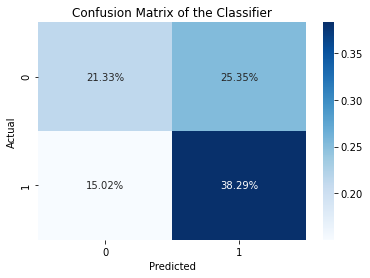

In [45]:
# Logistic calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = logreg_pred)

In [46]:
# zipping each feature name to its coefficient
logreg_model_values = zip(x_train.columns, logreg_fit.coef_.round(decimals = 3))

# setting up a placeholder list to store model features
logreg_model_lst = [('intercept', logreg_fit.intercept_.round(decimals = 2))]

# printing out each feature-coefficient pair one by one
for val in logreg_model_values:
    logreg_model_lst.append(val)

In [47]:
# appending to model_performance
model_performance_detail = pd.DataFrame(
                          {'Model Name'        : 'LogReg',
                           'Training Accuracy' : logreg_train_score,
                           'Testing Accuracy'  : logreg_test_score,
                           'AUC Score'         : logreg_auc_score,
                           'Confusion Matrix'  : [logreg_model_lst]})

#### 3) Full Tree

In [48]:
# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier()


# FITTING the training data
full_tree_fit = full_tree.fit(x_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(x_test)


# SCORING the model
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train,
                                                     y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test,
                                                     y_test).round(4))

# saving scoring data for future use
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy

print('Full Tree Train-Test Gap   :', abs(full_tree_train_score - full_tree_test_score).round(4))
logreg_test_gap = abs(full_tree_train_score - full_tree_test_score).round(4)


print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


# saving scoring data for future use
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

Full Tree Training ACCURACY: 0.6252
Full Tree Testing ACCURACY : 0.6131
Full Tree Train-Test Gap   : 0.0121
Full Tree AUC Score: 0.6045


In [49]:
# unpacking the confusion matrix
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = full_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {full_tree_tn}
False Positives: {full_tree_fp}
False Negatives: {full_tree_fn}
True Positives : {full_tree_tp}
""")


True Negatives : 4952
False Positives: 5480
False Negatives: 3165
True Positives : 8748



In [ ]:
# full_tree_calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = full_tree_pred)

In [51]:
# appending to model_performance
model_performance_detail = model_performance_detail.append(
                          {'Model Name'        : 'Full Tree',
                           'Training Accuracy' : full_tree_train_score,
                           'Testing Accuracy'  : full_tree_test_score,
                           'AUC Score'         : full_tree_auc_score,
                           'Confusion Matrix'  : (full_tree_tn,
                                                  full_tree_fp,
                                                  full_tree_fn,
                                                  full_tree_tp)},
                           ignore_index = True)

#### 4) Pruned Tree

In [52]:
# INSTANTIATING a classification tree object
pruned_tree = DecisionTreeClassifier(max_depth = 4,
                                     min_samples_leaf = 25,
                                     random_state = 219)


# FITTING the training data
pruned_tree_fit  = pruned_tree.fit(x_train, y_train)


# PREDICTING on new data
pruned_tree_pred = pruned_tree_fit.predict(x_test)


# SCORING the model
print('Pruned Tree Training ACCURACY:', pruned_tree_fit.score(x_train, y_train).round(4))
print('Pruned Tree Testing  ACCURACY:', pruned_tree_fit.score(x_test, y_test).round(4))

# saving scoring data for future use
pruned_tree_train_score = pruned_tree_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = pruned_tree_fit.score(x_test, y_test).round(4)   # accuracy

print('pruned Tree Train-Test Gap   :', abs(pruned_tree_train_score - pruned_tree_test_score).round(4))
pruned_tree_test_gap = abs(pruned_tree_train_score - pruned_tree_test_score).round(4)
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = pruned_tree_pred).round(4))


# saving scoring data for future use
pruned_tree_train_score = pruned_tree_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = pruned_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = pruned_tree_pred).round(4) # auc

Pruned Tree Training ACCURACY: 0.5792
Pruned Tree Testing  ACCURACY: 0.5758
pruned Tree Train-Test Gap   : 0.0034
AUC Score        : 0.5647


In [53]:
# unpacking the confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = pruned_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")


True Negatives : 4146
False Positives: 6286
False Negatives: 3193
True Positives : 8720



In [ ]:
# full_tree_calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = pruned_tree_pred)

In [54]:
# appending to model_performance
model_performance_detail = model_performance_detail.append(
                          {'Model Name'        : 'Pruned Tree',
                           'Training Accuracy' : pruned_tree_train_score,
                           'Testing Accuracy'  : pruned_tree_test_score,
                           'AUC Score'         : pruned_tree_auc_score,
                           'Confusion Matrix'  : (pruned_tree_tn,
                                                  pruned_tree_fp,
                                                  pruned_tree_fn,
                                                  pruned_tree_tp)},
                           ignore_index = True)

#### 5) GBM model

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

In [55]:
# INSTANTIATING the model with default parameters
full_gbm_default = GradientBoostingClassifier(loss          = 'deviance',
                                              learning_rate = 0.1,
                                              n_estimators  = 100,
                                              criterion     = 'friedman_mse',
                                              max_depth     = 3,
                                              warm_start    = False,
                                              random_state  = 219)


# FIT step is needed as we are not using .best_estimator
full_gbm_default_fit = full_gbm_default.fit(x_train, y_train)


# PREDICTING based on the testing set
full_gbm_default_pred = full_gbm_default_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', full_gbm_default_fit.score(x_train, y_train).round(4))
print('Testing ACCURACY :', full_gbm_default_fit.score(x_test, y_test).round(4))

print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = full_gbm_default_pred).round(4))

Training ACCURACY: 0.6067
Testing ACCURACY : 0.6045
AUC Score        : 0.5936


In [56]:
# INSTANTIATING the model object without hyperparameters

# I made several attempts to hyperparameter tuning
gbm_tuned = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.7000000000000001, loss='exponential',
                           max_depth=5, max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=750,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=219, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# FIT step is needed as we are not using .best_estimator
gbm_tuned_fit = gbm_tuned.fit(x_train, y_train)


# PREDICTING based on the testing set
gbm_tuned_pred = gbm_tuned_fit.predict(x_test)


# SCORING the results
print('gbm tuned Training ACCURACY:', gbm_tuned_fit.score(x_train, y_train).round(4))
print('gbm tuned Testing  ACCURACY:', gbm_tuned_fit.score(x_test, y_test).round(4))

# saving scoring data for future use
gbm_tuned_train_score = gbm_tuned_fit.score(x_train, y_train).round(4) # accuracy
gbm_tuned_test_score  = gbm_tuned_fit.score(x_test, y_test).round(4)   # accuracy

print('gbm tuned Train-Test Gap   :', abs(gbm_tuned_train_score - pruned_tree_test_score).round(4))
gbm_tuned_test_gap = abs(gbm_tuned_train_score - gbm_tuned_test_score).round(4)

print('gbm tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = gbm_tuned_pred).round(4))

# saving auc score
gbm_tuned_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = gbm_tuned_pred).round(4) # auc

gbm tuned Training ACCURACY: 0.625
gbm tuned Testing  ACCURACY: 0.6143
gbm tuned Train-Test Gap   : 0.0492
gbm tuned AUC Score        : 0.6055


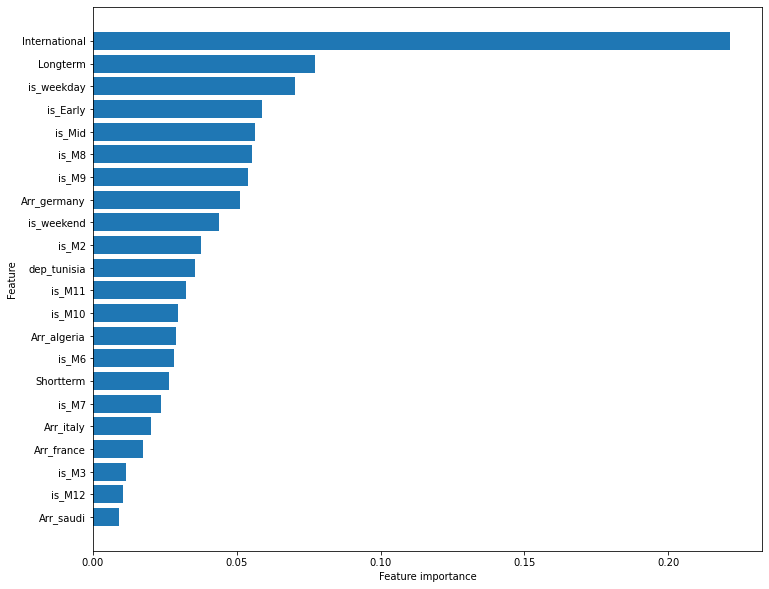

In [66]:
# plotting feature importances/ Check the feature Importance of variables
plot_feature_importances(model =gbm_tuned_fit, train = x_train, export = False)


In [58]:
# unpacking the confusion matrix
gbm_tuned_tn, \
gbm_tuned_fp, \
gbm_tuned_fn, \
gbm_tuned_tp = confusion_matrix(y_true = y_test, y_pred = gbm_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_tuned_tn}
False Positives: {gbm_tuned_fp}
False Negatives: {gbm_tuned_fn}
True Positives : {gbm_tuned_tp}
""")


True Negatives : 4934
False Positives: 5498
False Negatives: 3121
True Positives : 8792



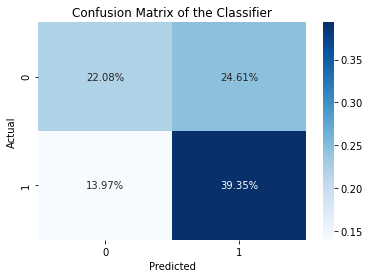

In [59]:
# full_tree_calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = gbm_tuned_pred)

In [60]:
# appending to model_performance
model_performance_detail = model_performance_detail.append(
                          {'Model Name'        : 'Tuned GBM',
                           'Training Accuracy' : gbm_tuned_train_score,
                           'Testing Accuracy'  : gbm_tuned_test_score,
                           'AUC Score'         : gbm_tuned_auc_score,
                           'Confusion Matrix'  : (gbm_tuned_tn,
                                                  gbm_tuned_fp,
                                                  gbm_tuned_fn,
                                                  gbm_tuned_tp)},
                           ignore_index = True)

#### 6) Random Forest

In [61]:
# INSTANTIATING a random forest model with default values
rf_model = RandomForestClassifier(n_estimators     = 500,
                                    criterion        = 'entropy',
                                    max_depth        = None,
                                    min_samples_leaf = 5,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)

# FITTING the training data
rf_model_fit = rf_model.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_model_fit_pred = rf_model_fit.predict(x_test)


# SCORING the results
print('rf_mdoel Training ACCURACY:', rf_model_fit.score(x_train, y_train).round(4))
print('rf_model Testing  ACCURACY:', rf_model_fit.score(x_test, y_test).round(4))

# saving scoring data for future use
rf_model_train_score = rf_model_fit.score(x_train, y_train).round(4) # accuracy
rf_model_test_score  = rf_model_fit.score(x_test, y_test).round(4)   # accuracy

print('rf_model Train-Test Gap   :', abs(rf_model_train_score - rf_model_test_score).round(4))
rf_model_test_gap = abs(rf_model_train_score - rf_model_test_score).round(4)


# saving AUC score
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_model_fit_pred).round(4))

# saving auc score
rf_model_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = rf_model_fit_pred).round(4) # auc


rf_mdoel Training ACCURACY: 0.6226
rf_model Testing  ACCURACY: 0.6142
rf_model Train-Test Gap   : 0.0084
AUC Score        : 0.6041


In [ ]:
# plotting feature importances
plot_feature_importances(model =rf_model_fit, train = x_train, export = False)

In [62]:
# unpacking the confusion matrix
rf_tn, \
rf_fp, \
rf_fn, \
rf_tp = confusion_matrix(y_true = y_test, y_pred = rf_model_fit_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {rf_tn}
False Positives: {rf_fp}
False Negatives: {rf_fn}
True Positives : {rf_tp}
""")


True Negatives : 4710
False Positives: 5722
False Negatives: 2898
True Positives : 9015



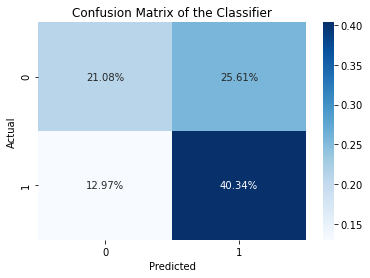

In [63]:
# full_tree_calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = rf_model_fit_pred)

In [64]:
# appending to model_performance
model_performance_detail = model_performance_detail.append(
                          {'Model Name'        : 'Tuned RF',
                           'Training Accuracy' : rf_model_train_score,
                           'Testing Accuracy'  : rf_model_test_score,
                           'AUC Score'         : rf_model_auc_score,
                           'Confusion Matrix'  : (rf_tn,
                                                  rf_fp,
                                                  rf_fn,
                                                  rf_tp)},
                           ignore_index = True)

model_performance_detail

,Model Name,Training Accuracy,Testing Accuracy,AUC Score,Confusion Matrix
0,LogReg,0.5982,0.5963,0.5876,"[(intercept, [-1.21]), (is_M2, [-0.533, 0.143,..."
1,Full Tree,0.6252,0.6131,0.6045,"(4952, 5480, 3165, 8748)"
2,Pruned Tree,0.5792,0.5758,0.5647,"(4146, 6286, 3193, 8720)"
3,Tuned GBM,0.6250,0.6143,0.6055,"(4934, 5498, 3121, 8792)"
4,Tuned RF,0.6226,0.6142,0.6041,"(4710, 5722, 2898, 9015)"


In [25]:
# Output binary models results
model_performance_detail.to_csv('detail_result.csv')